In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import r2_score
from scipy.stats import norm
from sklearn.cluster import KMeans
import random
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Default Parameters

In [33]:
# number of items
n = 20

# number of features
d = 5

# number of observations for each item
obs = 10

# number of clusters
z = 2

# number of trials
T = 100

# noise
sigma = 1
# prob
p, q = 1/3, 1/3

# Generate the simulated training and testing dataset and trains the models

In [34]:
def fit_models(Ru,Rl):
    

    r2_alg_t, r2_b1_t, r2_b2_t, r2_lasso_t, r2_clus_t,r2_true_t =  np.zeros(T), np.zeros(T), np.zeros(T),np.zeros(T), np.zeros(T),np.zeros(T)
    
    
    for t in range(T):

        # generate data
        data = np.random.rand(n*obs,d)
        data_test = np.random.rand(int(n*obs/2),d)

        # generate clusters and betas
        feature_dict = {}
        clus_dict = {} # might not be used depending on the feature dict

        for i in range(d):
            # whether this feature should be estimated at the department level
            feature_dict[i] = np.random.choice(['dept', 'clus', 'sku'], p = [p, q, 1-p-q])


        items = set(range(n))

        for i in range(z):
            clus_items = random.sample(items,int(n/z))
            clus_dict[i] = clus_items
            items = items - set(clus_items)

        # generate Beta
        beta_dict = {}
        num_cols = 0
        for i in range(d):
            if feature_dict[i] == 'dept':
                beta_dict[i] = (np.random.random_sample() - 0.5) * 10
                num_cols += 1
            elif feature_dict[i] == 'clus':
                beta_dict[i] = (np.random.random_sample(size = z) - 0.5) * 10
                num_cols += z
            else:
                beta_dict[i] = (np.random.random_sample(size = n) - 0.5) * 10
                num_cols += n

        X_true = np.zeros((n*obs, num_cols))
        X_test = np.zeros((int(n*obs/2), num_cols))

        beta = np.zeros(num_cols)
        count = 0
        for i in range(d):
            if feature_dict[i] == 'dept':
                beta[count] = beta_dict[i]
                X_true[:,count] = data[:,i]
                X_test[:,count] = data_test[:,i]

                count += 1

            elif feature_dict[i] == 'clus':
                for j in range(z):
                    clus_items = clus_dict[j]
                    for sku in clus_items:
                        X_true[sku*obs:(sku+1)*obs, count] = data[sku*obs:(sku+1)*obs, i]
                        X_test[int(sku*obs/2):int((sku+1)*obs/2), count] = data_test[int(sku*obs/2):int((sku+1)*obs/2), i]

                    beta[count] = beta_dict[i][j]
                    count += 1
            else:
                for j in range(n):
                    X_true[j*obs:(j+1)*obs, count] = data[j*obs:(j+1)*obs, i]

                    X_test[int(j*obs/2):int((j+1)*obs/2), count] = data_test[int(j*obs/2):int((j+1)*obs/2), i]

                    beta[count] = beta_dict[i][j]
                    count += 1

        epsilon = np.random.multivariate_normal(np.zeros(n*obs), np.identity(n*obs)*sigma)
        epsilon_test = np.random.multivariate_normal(np.zeros(int(n*obs/2)), np.identity(int(n*obs/2))*sigma)
        y = np.dot(X_true, beta) + epsilon
        y_test = np.dot(X_test, beta) + epsilon_test
        

        # model fitting - b1
        y_pred = []
        ols_models = {}
        for i in range(n):
            model_i = OLS(y[i*obs:(i+1)*obs], data[i*obs:(i+1)*obs,:], hasconst = False)
            ols_models[i] = model_i.fit()
            y_pred += list(ols_models[i].predict(data_test[int(i*obs/2):int((i+1)*obs/2),:]))

        r2_b1_t[t] = r2_score(y_test, np.array(y_pred))
        


        # model fitting - our method
        aggre_level = []
        clus_columns = []
        all_coeff = np.zeros((n,d))
        all_coeff[0,:] = ols_models[0].params
        n_cols_alg = 0

        for j in range(d):

            # a n-1 vector recording if two betas have the same mean
            test_j = np.zeros(n-1)

            for i in range(1,n):
                all_coeff[i,j] = ols_models[i].params[j]

                z_stat = ( np.abs(ols_models[0].params[j] - ols_models[i].params[j]) / 
                          np.sqrt(np.square(ols_models[0].bse[j]) + np.square(ols_models[i].bse[j])) )
                p_value = 1 - norm.cdf(z_stat)
                if p_value >= 0.05:  #P-value ->0.05
                    test_j[i-1] = 1

            if np.sum(test_j) >= Ru*(n-1):
                aggre_level.append('dept')
                n_cols_alg += 1

            elif np.sum(test_j) <= Rl*(n-1):
                aggre_level.append('sku')
                n_cols_alg += n

            else:
                aggre_level.append('clus')
                clus_columns.append(j)
                n_cols_alg += z

        if len(clus_columns) > 0:
            X_clus = all_coeff[:, clus_columns]
            kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)

        X_alg = np.zeros((n*obs, n_cols_alg))
        X_test = np.zeros((int(n*obs/2), n_cols_alg))

        count = 0
        for i in range(d):
            if aggre_level[i] == 'dept':
                X_alg[:,count] = data[:,i]
                X_test[:,count] = data_test[:,i]
                count += 1

            elif aggre_level[i] == 'clus':
                for j in range(z):
                    clus_items = list(np.where(kmeans.labels_ == j)[0])
                    for sku in clus_items:
                        X_alg[sku*obs:(sku+1)*obs, count] = data[sku*obs:(sku+1)*obs, i]
                        X_test[int(sku*obs/2):int((sku+1)*obs/2), count] = data_test[int(sku*obs/2):int((sku+1)*obs/2), i]


                    count += 1
            else:
                for j in range(n):
                    X_alg[j*obs:(j+1)*obs, count] = data[j*obs:(j+1)*obs, i]

                    X_test[int(j*obs/2):int((j+1)*obs/2), count] = data_test[int(j*obs/2):int((j+1)*obs/2), i]

                    count += 1


        model_0 = OLS(y, X_alg, hasconst = False)
        result = model_0.fit()
        r2_alg_t[t] = r2_score(y_test, result.predict(X_test))
        

        # model fitting - b2
        model_0 = OLS(y, data, hasconst = False)
        result = model_0.fit()
        r2_b2_t[t] = r2_score(y_test, result.predict(data_test))
        

        # model fitting - b1 Lasso
        y_pred = []
        for i in range(n):
            model_i = LassoCV(alphas=[0.01,0.1,1,10,100],max_iter=10000).fit(data[i*obs:(i+1)*obs,:], y[i*obs:(i+1)*obs])
            y_pred += list(model_i.predict(data_test[int(i*obs/2):int((i+1)*obs/2),:]))

        r2_lasso_t[t] = r2_score(y_test, np.array(y_pred))
        
        
        
        #other clustering
        X_clus = np.zeros((n, d))
        count = 0
        y_pred = np.zeros(int(n*obs/2))
        for i in range(n):
            X_clus[count, :] = np.mean(data[i*obs:(i+1)*obs,:], axis = 0)
            count += 1
        
        kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
        for i in range(z):
            clus_items = list(np.where(kmeans.labels_ == i)[0])
            base_rows = np.array(list(range(obs)))
            base_rows_test = np.array(list(range(int(obs/2))))
            rows = []
            test_rows = []
            for j in clus_items:
                rows += list(range( j*obs, (j+1)*obs ))
                test_rows += list(range( j*int(obs/2), (j+1)*int(obs/2) ))
            
            model_i = OLS(y[np.ix_(rows)], data[np.ix_(rows)], hasconst = False).fit()
            y_pred[np.ix_(test_rows)] = model_i.predict(data_test[np.ix_(test_rows)])

        r2_clus_t[t] = r2_score(y_test, y_pred)

    return np.mean(r2_alg_t), np.mean(r2_b1_t), np.mean(r2_b2_t), np.mean(r2_lasso_t), np.mean(r2_clus_t)
 

# Varying features

### Varying the number of items

In [14]:
list_n = [i for i in range(10,160,10)]

d=5
p=2/3
q=1/6
sigma=1
n=20
obs=10

r2_alg, r2_b1, r2_b2, r2_lasso, r2_clus = [], [], [], [],[]
for n in list_n:
    result_1, result_2, result_3, result_4,result_5 = fit_models(0.9,0.6)
    r2_alg.append(result_1)
    r2_b1.append(result_2)
    r2_b2.append(result_3)
    r2_lasso.append(result_4)
    r2_clus.append(result_5)
    print(n)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


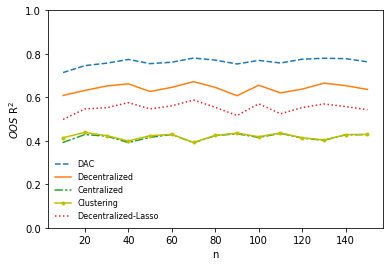

In [15]:
plt.plot(list_n, r2_alg,"--",label = 'DAC')
plt.plot(list_n, r2_b1,'',label = 'Decentralized')
plt.plot(list_n, r2_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_n, r2_clus,'y-o',markersize=3,label = 'Clustering')
plt.plot(list_n, r2_lasso,":",label = 'Decentralized-Lasso')


plt.legend(loc='best',frameon=False,prop={'size': 8})
plt.xlabel('n')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0,1.0)
plt.show()

### Varying the number of features

In [16]:
list_d = [i for i in range(5,16,1)]

obs=20
n=20
p=2/3
q=1/6
n = 20

r2_alg, r2_b1, r2_b2, r2_lasso, r2_clus = [], [], [], [],[]
for d in list_d:
    result_1, result_2, result_3, result_4,result_5 = fit_models(0.9,0.6)
    r2_alg.append(result_1)
    r2_b1.append(result_2)
    r2_b2.append(result_3)
    r2_lasso.append(result_4)
    r2_clus.append(result_5)
    print("features:",d)
    

features: 5
features: 6
features: 7
features: 8
features: 9
features: 10
features: 11
features: 12
features: 13
features: 14
features: 15


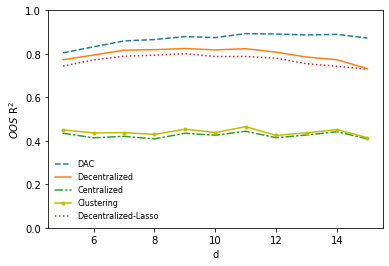

In [17]:
plt.plot(list_d, r2_alg,"--",label = 'DAC')
plt.plot(list_d, r2_b1,'',label = 'Decentralized')
plt.plot(list_d, r2_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_d, r2_clus,'y-o',markersize=3,label = 'Clustering')
plt.plot(list_d, r2_lasso,":",label = 'Decentralized-Lasso')


plt.legend(loc='best',frameon=False,prop={'size': 8})
plt.xlabel('d')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()

### Varying the number of observations

In [18]:
list_m = [i for i in range(10,55,5)]

n=20
p=2/3
q=1/6
d=5

r2_alg, r2_b1, r2_b2, r2_lasso, r2_clus= [], [], [], [],[]
for obs in list_m:
    result_1, result_2, result_3, result_4,result_5 = fit_models(0.9,0.6)
    r2_alg.append(result_1)
    r2_b1.append(result_2)
    r2_b2.append(result_3)
    r2_lasso.append(result_4)
    r2_clus.append(result_5)
    print("observations:",obs)

observations: 10
observations: 15
observations: 20
observations: 25
observations: 30
observations: 35
observations: 40
observations: 45
observations: 50


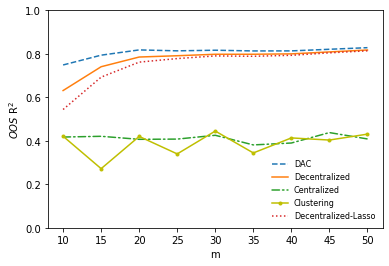

In [19]:
plt.plot(list_m, r2_alg,"--",label = 'DAC')
plt.plot(list_m, r2_b1,'',label = 'Decentralized')
plt.plot(list_m, r2_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_m, r2_clus,'y-o',markersize=3,label = 'Clustering')
plt.plot(list_m, r2_lasso,":",label = 'Decentralized-Lasso')


plt.legend(loc='best',frameon=False,prop={'size': 8})
plt.xlabel('m')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()

### Varying the noise magnitude

In [20]:
list_sigma = np.array([0.25,0.50,0.75,1.0,1.25,1.50,1.75,2.0])

obs=10
n=20
p=2/3
q=1/6
d=5

r2_alg, r2_b1, r2_b2, r2_lasso, r2_clus = [], [], [], [],[]
for sigma in list_sigma:
    result_1, result_2, result_3, result_4,result_5 = fit_models(0.9,0.6)
    r2_alg.append(result_1)
    r2_b1.append(result_2)
    r2_b2.append(result_3)
    r2_lasso.append(result_4)
    r2_clus.append(result_5)
    print("sigma:",sigma)

sigma: 0.25
sigma: 0.5
sigma: 0.75
sigma: 1.0
sigma: 1.25
sigma: 1.5
sigma: 1.75
sigma: 2.0


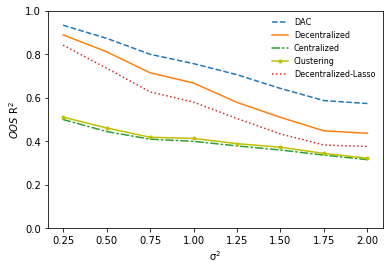

In [21]:
plt.plot(list_sigma, r2_alg,"--",label = 'DAC')
plt.plot(list_sigma, r2_b1,'',label = 'Decentralized')
plt.plot(list_sigma, r2_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_sigma, r2_clus,'y-o',markersize=3,label = 'Clustering')
plt.plot(list_sigma, r2_lasso,":",label = 'Decentralized-Lasso')


plt.legend(loc='best',frameon=False,prop={'size': 8})

c2 = "2"
label2 = r'σ$^{{{}}}$ '.format(c2)

plt.xlabel(label2)
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()

# Varying feature structure within the dataset

### Setting Probability of a feature being at the cluster level to 1/3 : q = 1/3

In [22]:
r2_alg, r2_b1, r2_b2, r2_lasso, r2_clus = [], [], [], [],[]


obs=10
n=20
d=5
sigma=1
q = 1/3
T=100

list_p = list(np.linspace(1/6,1-q,num=10,endpoint=False))

for p in list_p:

    result_1, result_2, result_3, result_4, result_5 = fit_models(0.9,0.6)

    r2_alg.append(result_1)
    r2_b1.append(result_2)
    r2_b2.append(result_3)
    r2_lasso.append(result_4)
    r2_clus.append(result_5)
    
    print('trial:', p)

trial: 0.16666666666666666
trial: 0.21666666666666667
trial: 0.26666666666666666
trial: 0.31666666666666665
trial: 0.3666666666666667
trial: 0.41666666666666674
trial: 0.4666666666666667
trial: 0.5166666666666667
trial: 0.5666666666666668
trial: 0.6166666666666667


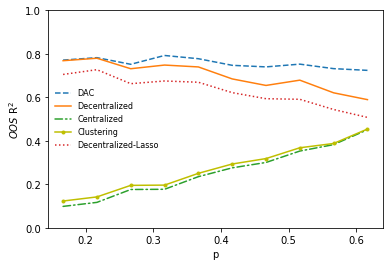

In [23]:
plt.plot(list_p, r2_alg,"--",label = 'DAC')
plt.plot(list_p, r2_b1,'',label = 'Decentralized')
plt.plot(list_p, r2_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_p, r2_clus,'y-o',markersize=3,label = 'Clustering')
plt.plot(list_p, r2_lasso,":",label = 'Decentralized-Lasso')


plt.legend(loc='best',frameon=False,prop={'size': 8})
plt.xlabel('p')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()

### Setting Probability of a feature being at the cluster level to 2/3: q =2/3

In [24]:
r2_alg, r2_b1, r2_b2, r2_lasso, r2_clus = [], [], [], [],[]

obs=10
n=20
d=5
q = 2/3
T=100
list_p = list(np.linspace(1/6,1-q,num=10,endpoint=False))

for p in list_p:

    result_1, result_2, result_3, result_4, result_5 = fit_models(0.9,0.6)

    r2_alg.append(result_1)
    r2_b1.append(result_2)
    r2_b2.append(result_3)
    r2_lasso.append(result_4)
    r2_clus.append(result_5)
    
    print('trial:', p)


trial: 0.16666666666666666
trial: 0.18333333333333332
trial: 0.2
trial: 0.21666666666666667
trial: 0.23333333333333334
trial: 0.25
trial: 0.26666666666666666
trial: 0.2833333333333333
trial: 0.30000000000000004
trial: 0.31666666666666665


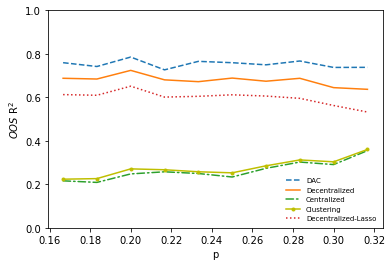

In [25]:
plt.plot(list_p, r2_alg,"--",label = 'DAC')
plt.plot(list_p, r2_b1,'',label = 'Decentralized')
plt.plot(list_p, r2_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_p, r2_clus,'y-o',markersize=3,label = 'Clustering')
plt.plot(list_p, r2_lasso,":",label = 'Decentralized-Lasso')


plt.legend(loc='best',frameon=False,prop={'size': 7})
plt.xlabel('p')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()

### Setting Probability of a feature being at the department level to 1/3: p = 1/3

In [26]:
r2_alg, r2_b1, r2_b2, r2_lasso, r2_clus = [], [], [], [],[]

T= 100
p = 1/3
list_q = list(np.linspace(1/6,1-p,num=10,endpoint=False))

for q in list_q:

    result_1, result_2, result_3, result_4, result_5 = fit_models(0.9,0.6)

    r2_alg.append(result_1)
    r2_b1.append(result_2)
    r2_b2.append(result_3)
    r2_lasso.append(result_4)
    r2_clus.append(result_5)
    
    print('trial:', q)


trial: 0.16666666666666666
trial: 0.21666666666666667
trial: 0.26666666666666666
trial: 0.31666666666666665
trial: 0.3666666666666667
trial: 0.41666666666666674
trial: 0.4666666666666667
trial: 0.5166666666666667
trial: 0.5666666666666668
trial: 0.6166666666666667


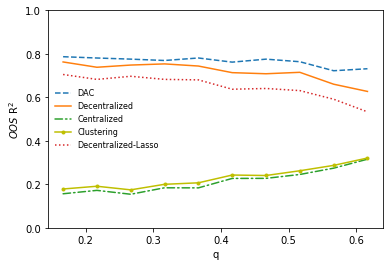

In [27]:
plt.plot(list_q, r2_alg,"--",label = 'DAC')
plt.plot(list_q, r2_b1,'',label = 'Decentralized')
plt.plot(list_q, r2_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_q, r2_clus,'y-o',markersize=3,label = 'Clustering')
plt.plot(list_q, r2_lasso,":",label = 'Decentralized-Lasso')

plt.legend(loc='best',frameon=False,prop={'size': 8})
plt.xlabel('q')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()

### Setting Probability of a feature being at the department level to 2/3: p =2/3

In [35]:
r2_alg, r2_b1, r2_b2, r2_lasso, r2_clus = [], [], [], [],[]

T = 100
p = 2/3
list_q = list(np.linspace(1/6,1-p,num=10,endpoint=False))

for q in list_q:

    result_1, result_2, result_3, result_4, result_5 = fit_models(0.9,0.6)

    r2_alg.append(result_1)
    r2_b1.append(result_2)
    r2_b2.append(result_3)
    r2_lasso.append(result_4)
    r2_clus.append(result_5)
    
    print('trial:', q)


trial: 0.16666666666666666
trial: 0.18333333333333332
trial: 0.2
trial: 0.21666666666666667
trial: 0.23333333333333334
trial: 0.25
trial: 0.26666666666666666
trial: 0.2833333333333333
trial: 0.30000000000000004
trial: 0.31666666666666665


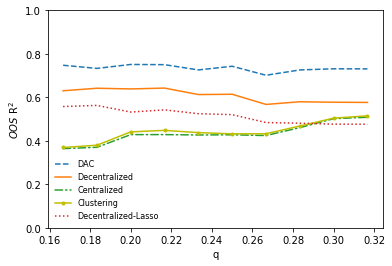

In [36]:
plt.plot(list_q, r2_alg,"--",label = 'DAC')
plt.plot(list_q, r2_b1,'',label = 'Decentralized')
plt.plot(list_q, r2_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_q, r2_clus,'y-o',markersize=3,label = 'Clustering')
plt.plot(list_q, r2_lasso,":",label = 'Decentralized-Lasso')

plt.legend(loc='best',frameon=False,prop={'size': 8})
plt.xlabel('q')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()